In [1]:
from collections import defaultdict, Counter
from operator import itemgetter
import re,operator
import bz2, json
from collections import defaultdict
import cmath
WORD_LEN_COEFF = 1
THRESHOLD_COEFF = 0.5
DROP = 2.1
DROP_1 = 2
AFFIX_LEN = 1

trie, voc, words = None, None, None


def main():
    global trie, words, voc
    
    voc = load_voc()
    voc2 = voc.copy()
    words = list(voc.keys())
    word_count = sum([voc[k] for k in voc])
    average_word_len = sum([len(w)*voc[w] for w in words]) / word_count
    len_search = int(average_word_len * WORD_LEN_COEFF) #это максимальная разрешенная длина аффикса
    print("{} словоформ, {} словоупотреблений, средняя длина слова {} ".format(len(words), word_count, average_word_len))

    # подсчет безусловных вероятностей букв
    # trie, prob = build_trie_and_prob(voc)
    for w in voc:
        voc[w]=1
        
  #  prob = json.load(open("prob.json", encoding="utf-8"))
    prob = defaultdict(int)
    total = 0
    for w in voc:
        for ch in w:
            prob[ch]+=1
        total+=len(w)
    for ch in prob:
        prob[ch]=prob[ch]/total
        
    def build_trie(words):
        root = {'n':0} #кол-во букв встречающихся в 
        for w in words: #для слова в списке 
            word = w[::-1] # переворачиваем список, читаем слово с конца
            current_dict = root
            for letter in word: #для буквы в слове
                current_dict = current_dict.setdefault(letter, {'n': 0}) #получить значение из словаря по ключу. 
                #Автоматически добавляет элемент словаря, если он отсутствует. 
            current_dict['#'] = True
            current_dict = root
            for letter in word: #для буквы в словаре
                current_dict['n']+=voc[w]
                current_dict = current_dict.setdefault(letter, {'n': 0})
            current_dict['n']+=voc[w]
            current_dict['#'] = True
        return root
    trie = build_trie(words)
    """"""
    print("Безусловные вероятности первых 10 букв:\n========================\n", 
        sorted([(letter,nv) for letter,nv in prob.items()], key=itemgetter(1), reverse=True)[:10])

    # подсчет условных вероятностей букв
    cond_prob = build_cond_prob(voc, prob, len_search)

    # информанты - это буквы с макс значением КФ в каждой позиции
    informants = find_informants(prob, cond_prob, len_search)
    print("ИНФОРМАНТЫ:\n===================")
    print(informants)

    # отправной аффикс начинаем строить с информанта имеющего max КФ
    affix=informants[0]
    affix=extend_right(*affix)
    affix=extend_left(affix, trie, len_search)
    print("ОТПРАВНОЙ АФФИКС:\n===================")    
    print(affix)



def load_voc():
    # Загрузить словарь количеств из файла.
    # Словарь содержит частоты слов в виде {слово: число вхождений в корпус, ... },
    # например {"көппөҕү" : 4, "хазар" : 3, ...}
    #
    # корпус в формате txt  занимет 174 МБ, словарь частот в json 10,4МБ,
    # после сжатия в формат .bz2 1,7 МБ
    svoc = bz2.BZ2File('voc.json.bz2', 'r').read().decode(encoding='utf-8')
    voc = json.loads(svoc)
    del svoc
    return voc


def build_trie_and_prob(voc):
    #подсчитываем частоты букв и строим дерево оконочаний
    prob = defaultdict(lambda: 0)
    trie = {'n':0}
    for w,n in voc.items(): #для каждого слова в списке
        word = w[::-1]  # переворачиваем слово, читаем слово с конца
        current_dict = trie
        trie['n'] += n
        for letter in word:  # для буквы в слове
            prob[letter]+=n
            current_dict = current_dict.setdefault(letter, {'n': 0}) #получить значение из словаря по ключу.
                                                                     #Автоматически добавляет элемент словаря, если он отсутствует.
            current_dict['n']+=n
        current_dict['#'] = n

    total = sum([n for n in prob.values()])#84263863
    for k,v in prob.items():
        prob[k] = v/total

    return trie, prob


def build_cond_prob(voc, prob, len_search):
    letters = list(prob.keys())

    cond_prob = defaultdict(lambda: 0) #словарь для условных вероятностей
    total = defaultdict(lambda: 0)

    for word,n in voc.items():#для слова в словаре
        positions = range(-min(len_search, len(word) - 2), 0) # from -7 to 0
        for i in positions:
            cond_prob[(i, word[i])] += n
            total[i] += n # dictionary with prob of char words?

    for posChar in cond_prob: #получаем из частот вероятности
        i = posChar[0]
        cond_prob[posChar] /= total[i]

    return cond_prob


def find_informants(prob, cond_prob, len_search):
    max_cond = defaultdict(lambda: 0.0)
    maxlet = ['']*8
    #для каждой позиции ищем букву с наибольшим значением условной вероятности,
    for posChar in cond_prob:#цикл по позициям букв в условной вероятности
        aff_len = posChar[0]
        if cond_prob[posChar] > max_cond[aff_len]:
            max_cond[aff_len] = cond_prob[posChar]
            maxlet[-aff_len] = posChar[1]

    print("Наиболее частые буквы по позициям:\n============================\n", maxlet[-1:0:-1],"\n")

    print("Максимальные вероятности по позициям:\n============================\n", max_cond,"\n")
    #порог медиального разбиения - половина условной вероятности , буквы с УВ не меньше порога - верхнее подмножеств
    cond_prob_sup = {}
    for posChar in cond_prob:
            i = posChar[0]
            if cond_prob[posChar] > THRESHOLD_COEFF * max_cond[i]:
                cond_prob_sup[posChar] = cond_prob[posChar]

    # КФ = условная вер по данной позиции / безусл вероятность
    cf = {}
    for posChar in cond_prob_sup:
        char = posChar[1]
        cf[posChar] = cond_prob_sup[posChar] / prob[char]

    print("КФ для верхних подмножества:\n====================\n");
    for aff_len in set(map(itemgetter(0), cf.keys())):
        print(aff_len, "**")
        for k,v in cf.items():
            if k[0] == aff_len:
                print(k[1], "{:.4f}".format(v), end="  ")
        print("")

    # информанты - это буквы с макс значением КФ в каждой позиции
    informants = []
    for aff_len in range(-len_search, 0):
        kmax = max({k for k in cf if k[0] == aff_len}, key=lambda k: cf[k])
        informants.append((kmax[1], aff_len, cf[kmax]))

    informants.sort(key = itemgetter(2), reverse=True)
    return informants


def extend_right(char, pos, cf):
    if pos == -1:#если информант в последней позиции, то расширять некуда
        return char #возвращаем информант как аффикс
    d = defaultdict(int)
    for w,n in voc.items():#для буквы и частоты в словаре
        if w[pos:pos+1]==char: #если буква в позиции равна нашей, то посчитаем это окончание
            d[w[pos+1:]]+=n
    return char+max(d.keys(), key=lambda end: d[end]) #прибавляем к информанту самое частое окончание


def extend_left(affix, trie, len_search):
    #расширяем аффикс влево используя trie

    current_dict = trie
    for ch in affix[::-1]:
        current_dict = current_dict[ch]

    aff_len = len(affix)

    """ 
    Для поиска буквы слева:
        идем по дереву trie
        по две самые частотные буквы делим друг на друга, при мере перепада большей 1.5 прибавляем к информанту более частую из них.
       Иначе начинаем рассматривать по две самые частотные буквы/на следующие две, 
    если мера перепада в одной из них больше двух, то из данной пары берем более частотную и прибавляем ее к аффиксу. 
    """
    #пока позиция символа в слове больше разрешенной длины аффикса
    while aff_len < len_search:
        #составляем список всех букв предшествующих аффиксу с количествами
        L = [(l, current_dict[l]["n"]) for l in current_dict.keys() if l not in '#n']
        #сортируем по количествам
        L.sort(key = itemgetter(1), reverse = True)
        #if affix=='нан':
            #import pdb
            #pdb.set_trace()
        ch = L[0][0]
        if L[0][1] > DROP*L[1][1]:
            affix = ch + affix
            current_dict = current_dict[ch]
        else:
            if (L[0][1]+L[1][1]) / (L[2][1]+L[3][1]) > 2:
                affix = ch + affix
                current_dict = current_dict[ch]
            else:
                break
        aff_len+=1

    return affix

#main()


def more(voc):
    #базы первого вида
    bases = [w[0:-aff_len] for w,n in voc.items() if w[-aff_len:]==affix and n>3] #отбрасываем информантный аффикс и получаем базы 1го вида
    #bases.sort(key = itemgetter(1), reverse = True)
    bases = sorted(bases)
    #спектр остатков первого вида, т.е. находим остальные слова содержащие базы 1го вида, и отсекаем их и получаем СОПП
    ostat = defaultdict(int)
    for b in bases:
        for w,n in voc.items():
            if not w.startswith(b):
                continue
            ostat[w[len(b)+1:]]+=n
    
    #print(ostat)

    # теперь нужно упорядочить спектр остатков по частоте в убывающем порядке
    ostat=ostat.sort(key = itemgetter(0), reverse=True)
    #выделяем из спектра сотатков верхнее подмножество, для р.яз первые 6 аффиксов спектра
    # - для каждой позиции находится буква с наибольшим УВ, половина ее УВ - порог медиального разбиения
    #буквы, УВ которых не меньше данного порога входят в верхнее подмножество

    #определим независимую вероятность буквосочетания(остатков верхнего подмножества), как произведение независимых вероятностей букв входящих в него.
    # uncond_prob = defaultdict()
    # for k,v in ostat.items():
    #     for
    #         uncond_prob[k] *= prob[k]

    #затем находим условную вероятность остатка(?), по максимальному значению условной вероятности определяем
    #второй информантный аффикс по максимуму условной вероятности (в верхнем подмножестве)
    #сопоставляем количество основ сочетающихся с первым информантным аффиксом и
    #число основ со вторым информантным аффиксом стр38

    #Языковой шлейф. Шлейфовый порог при работе с базами n-го вида - выберем число n
    # т.е. убираем из списка баз все основы с суммарной синтагматической встречаемостью(вероятность относительно текста)
    #с любыми остатками, меньшую или равную n
    #полученный список будет содержать М баз n-го вида

    #после применения шлейфового порога и вычисления коэффициента редукции вычислим меру редукции

    # Compute reduction coefficient
   # k = 10**(cmath.log(average_word_len, 10)\
     #               / (1+0.02 * cmath.log( len(voc), 10)) )
        # Compute reduction threshold
    #thres_reduction = 1 / average_word_len
    return ostat


In [2]:
main()

386233 словоформ, 11859267 словоупотреблений, средняя длина слова 7.1053179762290535 
Безусловные вероятности первых 10 букв:
 [('а', 0.1420442067348661), ('т', 0.08712086651633842), ('р', 0.07405317921122184), ('н', 0.06774952517243932), ('ы', 0.06642568896415411), ('э', 0.05933604560312015), ('и', 0.0553869165240483), ('л', 0.049909338246668336), ('о', 0.04030310266579739), ('у', 0.037736340914752864)]
Наиболее частые буквы по позициям:
 ['а', 'а', 'а', 'а', 'т', 'а', 'н'] 

Максимальные вероятности по позициям:
 defaultdict(<function find_informants.<locals>.<lambda> at 0x0000012B0D222840>, {-6: 0.14554599272113838, -5: 0.13515378690040863, -4: 0.14630285323283118, -3: 0.15029051000645577, -2: 0.23001205041916198, -1: 0.25575392557539256, -7: 0.14136783470662562}) 

КФ для верхних подмножества:

-1 **
н 3.7750  р 1.9042  а 1.0816  
-7 **
а 0.9952  л 1.5093  т 0.9618  
-6 **
а 1.0247  т 1.0564  
-5 **
а 0.9515  т 1.3650  р 0.9999  
-4 **
а 1.0300  ы 1.5320  т 1.3352  
-3 **
н 1.3587 

In [5]:
voc0=load_voc()
len([v for k,v in voc0.items() if v==1])

177212

In [32]:
prob=defaultdict(int)
for word in voc0:
    prob[word]+=1
prob   

defaultdict(int,
            {'хоруунан': 1,
             'хазар': 1,
             'атааннааһыы': 1,
             'көппөҕү': 1,
             'быраҕылыннылар': 1,
             'бултарбыттан': 1,
             'кэмчилэр': 1,
             'моҥуохтара': 1,
             'ее': 1,
             'ыһылыннарбыт': 1,
             'тымныйбатаҕа': 1,
             'пшевозник': 1,
             'юристаахтара': 1,
             'дьээбэ': 1,
             'туораамаары': 1,
             'куубатынан': 1,
             'степановичтыын': 1,
             'сэрэппэт': 1,
             'болуоппутугар': 1,
             'квартилаах': 1,
             'ню': 1,
             'сүрэхпэр': 1,
             'пиибэлээһини': 1,
             'түһүммүт': 1,
             'быргыччы': 1,
             'рейкъявик': 1,
             'ааһыннылар': 1,
             'быыбардана': 1,
             'маҕаһыыныттан': 1,
             'төлөрүйдүлэр': 1,
             'чоргуйбутунан': 1,
             'чеботарев': 1,
             'хаптасовка': 1,
     

In [10]:
prob = defaultdict(int)
total = 0
for w in voc:
        for ch in w:
            prob[ch]+=1
        total+=len(w)
total

4066213

In [3]:
i=0
for k,v in voc.items():
    if i>15: break
    print(k, v)
    i+=1

хоруунан 1
хазар 1
атааннааһыы 1
көппөҕү 1
быраҕылыннылар 1
бултарбыттан 1
кэмчилэр 1
моҥуохтара 1
ее 1
ыһылыннарбыт 1
тымныйбатаҕа 1
пшевозник 1
юристаахтара 1
дьээбэ 1
туораамаары 1
куубатынан 1


In [7]:
affix='арыттан'

In [12]:
bases = [w[0:-7] for w,n in voc.items() if w[-7:]==affix and n>3]
len(bases) ,bases#bases 1 type

(448,
 ['мындаал',
  'булт',
  'тут',
  'ууст',
  'талаанн',
  'источникт',
  'ампаард',
  'туст',
  'уорҕал',
  'баст',
  'турбутт',
  'уолл',
  'тутуул',
  'онтул',
  'туппутт',
  'хаһаакт',
  'атт',
  'баһылыкт',
  'сыһыаннаһ',
  'туһал',
  'форумн',
  'сыһыаннаһалл',
  'салайааччыл',
  'таҥаст',
  'былаанн',
  'баһаард',
  'дьахт',
  'суолл',
  'уулуссал',
  'ыҥырбытт',
  'хааһынал',
  'ааҕааччыл',
  'ахсаанн',
  'таба',
  'журналист',
  'бааһынал',
  'уустукт',
  'талабырдьытт',
  'быыкаал',
  'дьарыкт',
  'сыанал',
  'буорд',
  'таһымн',
  'уураахт',
  'толоруул',
  'студенн',
  'опытт',
  'ыйаахт',
  'репертуард',
  'специалист',
  'наборд',
  'кутталл',
  'баралл',
  'утуй',
  'кыыст',
  'содулл',
  'тустуукт',
  'арыыл',
  'туруор',
  'сарынн',
  'улаҕал',
  'кыахтаммытт',
  'аймахт',
  'артыыст',
  'ба',
  'уолатт',
  'кыһалҕал',
  'быыст',
  'майгыл',
  'учуонайд',
  'уурулл',
  'тард',
  'уорганн',
  'лааҕырд',
  'хаартыскал',
  'архыыпт',
  'тулут',
  'боппуруост',
  'атты

In [27]:
for i in range(0, 5):
    slovoformy = [e for e,n in voc.items() if e.startswith(bases[i]) and  not e.endswith(affix)]
    print(slovoformy)

['мындааларыгар', 'мындааларын']
['бултарбыттан', 'бултаппата', 'бултаабата', 'бултуйбуттарын', 'бултааччыбыт', 'бултаатыбыт', 'бултастыҥ', 'бултаабаппыт', 'бултанар', 'бултанара', 'бултуубут', 'бултаахтара', 'бултуйдум', 'бултуйуубутун', 'бултуйалларын', 'бултааһынтан', 'бултуйбуккун', 'бултуйбут', 'бултаабыппыт', 'бултаспаккабын', 'бултуохтааххын', 'бултамматын', 'бултуурбутугар', 'бултаһыы', 'бултаһабын', 'бултуйдахтарына', 'бултуон', 'бултаныллыахтаах', 'бултаатаҕын', 'бултааччы', 'бултаатахха', 'бултуйбуттара', 'бултуйа', 'бултааһыннарын', 'бултааһыннарыгар', 'бултаабыккыттан', 'бултуурга', 'бултуйдугут', 'бултаттахтарына', 'бултуйбутум', 'бултуом', 'бултууру', 'бултааһыммар', 'бултаһыан', 'бултаспаталлар', 'бултаабаппын', 'бултаналларый', 'бултаһар', 'бултааһыммытыгар', 'бултатаары', 'бултаатыгыт', 'бултаһыахпытын', 'бултуйуоххун', 'бултана', 'бултуйаммыт', 'бултуйдубут', 'бултаатыннар', 'бултаһардыы', 'бултаппакка', 'бултууллара', 'бултуоҥ', 'бултааҕа', 'бултаһыым', 'бултуйбутут

['уустугурдубуппут', 'уустугуртулар', 'уустугурдан', 'уустугуруо', 'уустуктанар', 'уустуктартан', 'уустугуруон', 'уустугурарын', 'уустуктарга', 'уустугурдубакка', 'уустардаахпыт', 'уустугура', 'уустугарар', 'уустугурдар', 'уустаһыы', 'уустуктара', 'уустугар', 'уустугурта', 'уустугуран', 'уустугурбут', 'уустугурдуо', 'уустаахтарын', 'уустуктааҕа', 'уустуккун', 'уустуктарбыт', 'уустуктаммыт', 'уустары', 'уустугурдуһар', 'уустуйа', 'уустугурбутун', 'уустаахтарбытын', 'уустаах', 'уустугурдумаҥ', 'уустугурпута', 'уустугурдаргыттан', 'уустугурдалларын', 'уустугурда', 'уустугурбута', 'уустуктардааҕынан', 'уустарыгар', 'уустарбыт', 'уустардаах', 'уустукпут', 'уустугурдаҕына', 'уустугурбуттарга', 'уустан', 'уустуктарын', 'уустугурарый', 'уустугурдубуттарын', 'уустугун', 'уустаахпыт', 'уустугурдубутун', 'уустугурдаллара', 'уустугурар', 'уустара', 'уустугуруу', 'уустукка', 'уустуктар', 'уустугурдумаары', 'уустугу', 'уустугунан', 'уустугурбутугар', 'уустуктары', 'уустугурбутунан', 'уустарабыт', 'у

In [28]:
ends = [w[-7:] for w,n in voc.items() if w.startswith(bases[0]) and n>3]
ends

['арыттан', 'ларыгар', 'ааларын']

In [29]:
for i in range(0, 5):
    end = [w[-(len(w)-len(bases[i])):] for w,n in voc.items() if w.startswith(bases[i]) and  not w.endswith(affix)]
    print(end)

['арыгар', 'арын']
['арбыттан', 'аппата', 'аабата', 'уйбуттарын', 'ааччыбыт', 'аатыбыт', 'астыҥ', 'аабаппыт', 'анар', 'анара', 'уубут', 'аахтара', 'уйдум', 'уйуубутун', 'уйалларын', 'ааһынтан', 'уйбуккун', 'уйбут', 'аабыппыт', 'аспаккабын', 'уохтааххын', 'амматын', 'уурбутугар', 'аһыы', 'аһабын', 'уйдахтарына', 'уон', 'аныллыахтаах', 'аатаҕын', 'ааччы', 'аатахха', 'уйбуттара', 'уйа', 'ааһыннарын', 'ааһыннарыгар', 'аабыккыттан', 'уурга', 'уйдугут', 'аттахтарына', 'уйбутум', 'уом', 'ууру', 'ааһыммар', 'аһыан', 'аспаталлар', 'аабаппын', 'аналларый', 'аһар', 'ааһыммытыгар', 'атаары', 'аатыгыт', 'аһыахпытын', 'уйуоххун', 'ана', 'уйаммыт', 'уйдубут', 'аатыннар', 'аһардыы', 'аппакка', 'ууллара', 'уоҥ', 'ааҕа', 'аһыым', 'уйбутуттан', 'ааһыныгар', 'уйбакка', 'аспытым', 'арын', 'аммат', 'ааҕынан', 'уйаллар', 'уйуҥ', 'аабытын', 'уйбаттар', 'уйбуппун', 'аһыаххын', 'атан', 'аммыт', 'уубун', 'уйбатаҕын', 'аһаҕын', 'уйдуҥ', 'ааҥ', 'уой', 'анан', 'уйбуккут', 'анаат', 'аһыах', 'аһалларыгар', 'ууһулар',

['угурдубуппут', 'угуртулар', 'угурдан', 'угуруо', 'уктанар', 'уктартан', 'угуруон', 'угурарын', 'уктарга', 'угурдубакка', 'ардаахпыт', 'угура', 'угарар', 'угурдар', 'аһыы', 'уктара', 'угар', 'угурта', 'угуран', 'угурбут', 'угурдуо', 'аахтарын', 'уктааҕа', 'уккун', 'уктарбыт', 'уктаммыт', 'ары', 'угурдуһар', 'уйа', 'угурбутун', 'аахтарбытын', 'аах', 'угурдумаҥ', 'угурпута', 'угурдаргыттан', 'угурдалларын', 'угурда', 'угурбута', 'уктардааҕынан', 'арыгар', 'арбыт', 'ардаах', 'укпут', 'угурдаҕына', 'угурбуттарга', 'ан', 'уктарын', 'угурарый', 'угурдубуттарын', 'угун', 'аахпыт', 'угурдубутун', 'угурдаллара', 'угурар', 'ара', 'угуруу', 'укка', 'уктар', 'угурдумаары', 'угу', 'угунан', 'угурбутугар', 'уктары', 'угурбутунан', 'арабыт', 'уктардааҕыттан', 'угурдаҕын', 'уун', 'уктааҕый', 'угурдуу', 'уктаахпыт', 'арынан', 'угурууһу', 'ардааххыт', 'аргыт', 'уктаах', 'угурдубатым', 'угурдубуттар', 'угурдуон', 'угурдара', 'уктарынан', 'арбытын', 'угурдубута', 'ааҕын', 'угуттан', 'уйаҕа', 'угурбуттары

In [13]:
ostat = defaultdict(int)
for b in bases:
    for w,n in voc.items():
            if not w.startswith(b):
                continue
            ostat[w[len(b):]]+=n#было длина + 1

In [ ]:
ostat_sort=sorted(ostat.items(), key=lambda k_v: k_v[1], reverse=True)
#ostat_sort=ostat.sort(key = itemgetter(0), reverse=True)
len(ostat_sort)

In [34]:
len_search=7
cond_prob_ost=defaultdict(int)
prob = defaultdict(int)
for word,n in ostat_sort:
        print((word,n)[1])

291710
181755
173776
89903
89577
86976
77351
51116
49089
39331
39118
37611
34392
33994
33744
33468
30095
28047
26992
24862
20671
19649
19636
18921
18432
17761
16017
16008
15542
15317
15297
15284
15249
15214
15211
15211
15190
14929
14869
14048
13840
13786
11156
11155
11085
10480
10391
10135
10029
9564
9459
9417
9405
9134
8807
8341
8314
8312
8191
8162
8125
8124
8081
8037
7740
7728
7672
7480
7329
7306
7300
7259
7170
7148
7086
7080
7076
6972
6937
6895
6893
6838
6807
6791
6734
6705
6661
6633
6619
6526
6409
6402
6304
6270
6238
6203
6197
6170
6068
5978
5845
5642
5624
5607
5438
5410
5386
5267
5161
5113
5091
5088
4978
4968
4942
4934
4885
4877
4806
4804
4793
4730
4727
4667
4664
4588
4581
4457
4445
4421
4356
4295
4254
4254
4177
4140
4114
4075
4075
4073
4055
4055
3910
3885
3878
3874
3867
3813
3790
3770
3769
3749
3747
3739
3684
3684
3661
3598
3501
3499
3493
3490
3486
3481
3438
3419
3392
3379
3377
3356
3356
3332
3295
3278
3251
3193
3152
3114
3044
3044
3023
3021
3007
2999
2993
2979
2979
2972
2962
295

160
160
160
160
160
159
159
159
159
159
159
159
159
159
159
159
158
158
158
158
158
158
157
157
157
157
157
157
157
157
157
157
157
157
157
157
157
157
156
156
156
156
156
156
156
156
156
156
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
153
153
153
153
153
153
153
153
153
153
153
153
153
153
152
152
152
152
152
152
152
152
152
152
152
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
150
150
150
150
150
150
150
150
150
150
150
150
150
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
148
148
148
148
148
148
148
148
148
148
148
148
148
148
148
148
147
147
147
147
147
147
147
147
147
147
147
147
147
146
146
146
146
146
145
145
145
145
145
144
144
144
144
144
144
144
144
144
144
144
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
142
142
142
142
142
142
142
142
142
142
142
142
142
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
140
140
140


43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
43
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
41
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
3

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
1

12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
1

7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [35]:
cond_prob1 = defaultdict(lambda: 0) #словарь для условных вероятностей
total1 = defaultdict(lambda: 0)
for word,n in ostat_sort:
    #для остатков
        positions = range(-min(len_search, len(word) - 2), 0) # from -7 to 0
        for i in positions:
            cond_prob1[(i, word[i])] += n
            total1[i] += n # dictionary with prob of char words?
cond_prob1

defaultdict(<function __main__.<lambda>>,
            {(-7, 'а'): 77944,
             (-7, 'б'): 22235,
             (-7, 'в'): 137,
             (-7, 'г'): 4708,
             (-7, 'д'): 11444,
             (-7, 'е'): 1454,
             (-7, 'ж'): 536,
             (-7, 'з'): 189,
             (-7, 'и'): 24946,
             (-7, 'й'): 6719,
             (-7, 'к'): 8478,
             (-7, 'л'): 59747,
             (-7, 'м'): 7125,
             (-7, 'н'): 20725,
             (-7, 'о'): 9680,
             (-7, 'п'): 7432,
             (-7, 'р'): 23421,
             (-7, 'с'): 10297,
             (-7, 'т'): 45596,
             (-7, 'у'): 28986,
             (-7, 'ф'): 15,
             (-7, 'х'): 19633,
             (-7, 'ц'): 64,
             (-7, 'ч'): 6598,
             (-7, 'ш'): 102,
             (-7, 'щ'): 81,
             (-7, 'ы'): 66064,
             (-7, 'ь'): 6024,
             (-7, 'э'): 27796,
             (-7, 'ю'): 36,
             (-7, 'я'): 75,
             (-7, 'ё'): 10,
 

In [36]:
for posChar in cond_prob1: #получаем из частот вероятности
        i = posChar[0]
        cond_prob1[posChar] /= total1[i]

In [37]:
cond_prob1

defaultdict(<function __main__.<lambda>>,
            {(-7, 'а'): 0.1495529375647569,
             (-7, 'б'): 0.042662803637898615,
             (-7, 'в'): 0.00026286503703135193,
             (-7, 'г'): 0.009033347403967919,
             (-7, 'д'): 0.02195786484515906,
             (-7, 'е'): 0.0027898230937488007,
             (-7, 'ж'): 0.0010284354733489389,
             (-7, 'з'): 0.0003626386277293833,
             (-7, 'и'): 0.04786446141448252,
             (-7, 'й'): 0.012891899151924478,
             (-7, 'к'): 0.016266932729575193,
             (-7, 'л'): 0.11463793698914003,
             (-7, 'м'): 0.01367090064852834,
             (-7, 'н'): 0.03976553206185963,
             (-7, 'о'): 0.018573237653018153,
             (-7, 'п'): 0.014259948578226333,
             (-7, 'р'): 0.04493840899497294,
             (-7, 'с'): 0.019757089681108255,
             (-7, 'т'): 0.08748608925898922,
             (-7, 'у'): 0.05561610192256034,
             (-7, 'ф'): 2.8780843470585978e

In [53]:
max_cond1 = defaultdict(lambda: 0.0)
maxlet1 = ['']*8
    #для каждой позиции ищем букву с наибольшим значением условной вероятности,
for posChar in cond_prob1:#цикл по позициям букв в условной вероятности
        aff_len = posChar[0]
        if cond_prob1[posChar] > max_cond1[aff_len]:
            max_cond1[aff_len] = cond_prob1[posChar]
            maxlet1[-aff_len] = posChar[1]
max_cond1
maxlet1

['', 'н', 'а', 'а', 'ы', 'а', 'а', 'а']

In [51]:
cond_prob_sup1 = {}#верхнее подмножество
for posChar in ostat_sort:
        i = posChar[0]
        if cond_prob1[posChar] > THRESHOLD_COEFF * max_cond1[i]:
            cond_prob_sup1[posChar] = cond_prob1[posChar]
cond_prob_sup1

{}

In [50]:
for word in ostat_sort:
        pos=range(-len(word[0]),0)
        for i in positions:
            cond_prob1[(i, word[i])] += 1
            #total1[i] += n

IndexError: tuple index out of range

In [8]:
def n(a):
    current_node = trie
    for char in a[::-1]:
        current_node = current_node[char]
    return current_node['n']

def n2(a):#функция принимает строку
    current_node = trie
    for char in a[::-1]:
        current_node = current_node[char]
    return sorted([(k,subtree['n']) for k, subtree in current_node.items() if k not in '#n'], key=itemgetter(1), reverse=True)


In [9]:
n2('ртан')

[('а', 1579),
 ('ы', 108),
 ('о', 94),
 ('у', 57),
 ('е', 36),
 ('т', 9),
 ('и', 8),
 ('д', 3),
 ('я', 2),
 ('в', 2),
 ('п', 1),
 ('ё', 1),
 ('ю', 1),
 ('г', 1),
 ('н', 1)]

In [41]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
def diag(a):
    current_node = trie
    for char in a[::-1]:
        current_node = current_node[char]
    pairs = sorted([(k,subtree['n']) for k, subtree in current_node.items() if k not in '#n'], 
                   key=itemgetter(1), 
                   reverse=True)
    kol = [p[1] for p in pairs]
    chs = [p[0] for p in pairs]
    plt.figure(figsize=(14,7))
    plt.bar(np.arange(len(kol)), kol, tick_label=chs)
    plt.show()

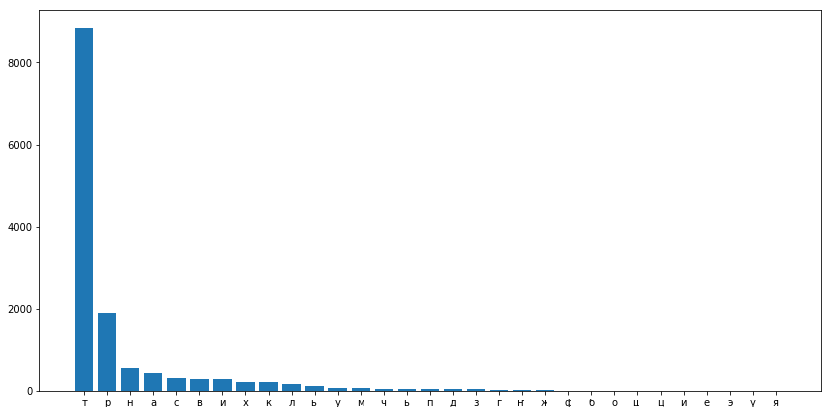

In [42]:
diag('тан')

# diag('ртан')

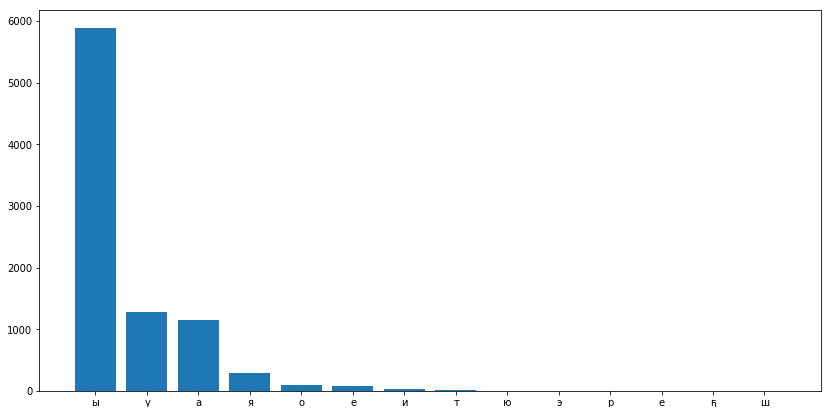

In [39]:
diag('ттан')

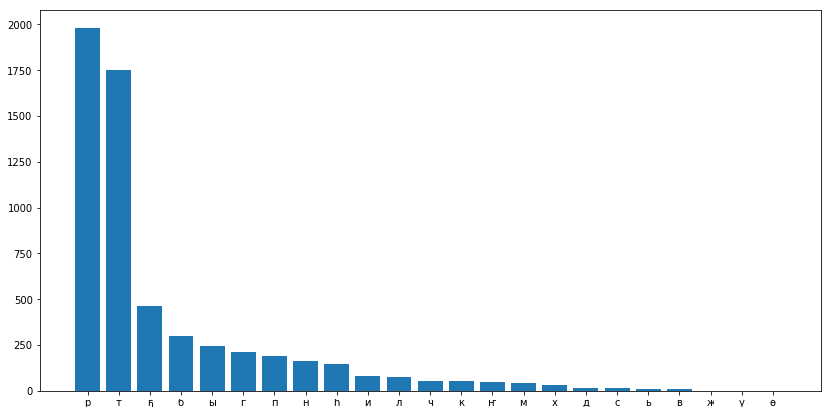

In [40]:
diag('ыттан')

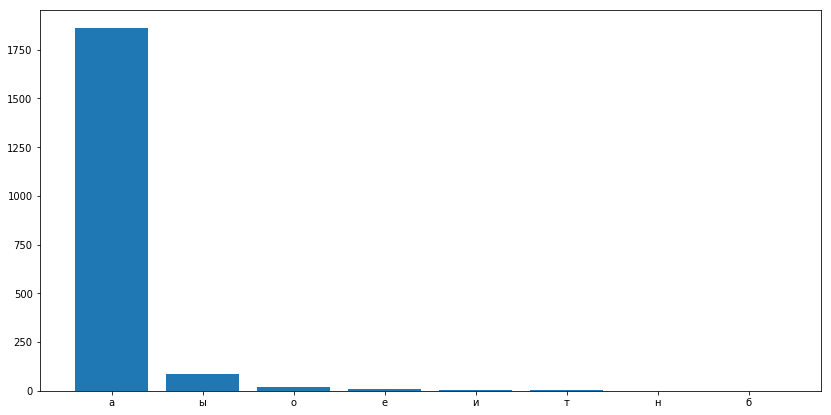

In [43]:
diag('рыттан')

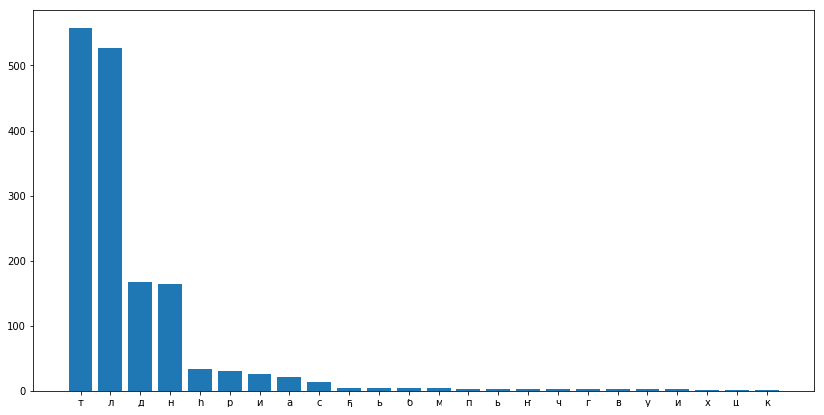

In [37]:
diag('артан')

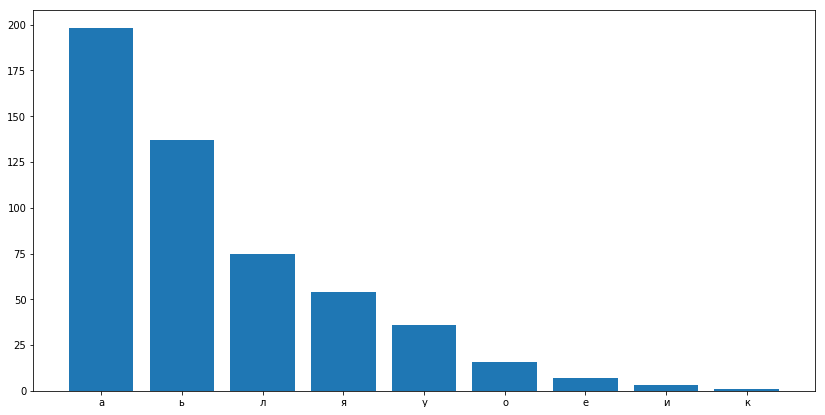

In [38]:
diag('лартан')

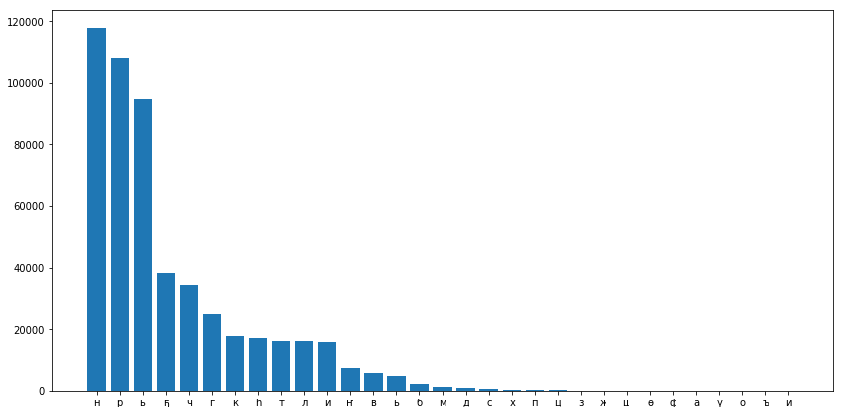

In [74]:
diag('ы')

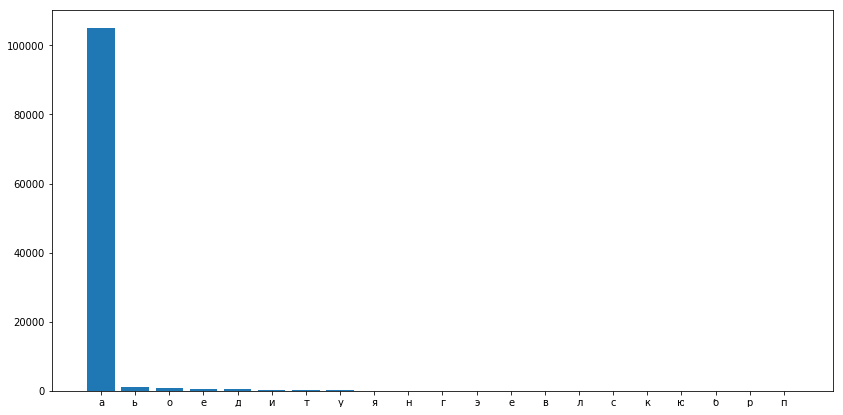

In [76]:
diag('ры')

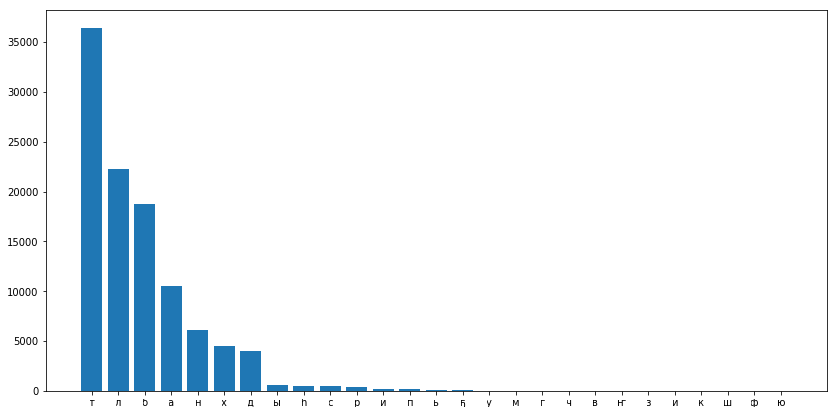

In [77]:
diag('ары')

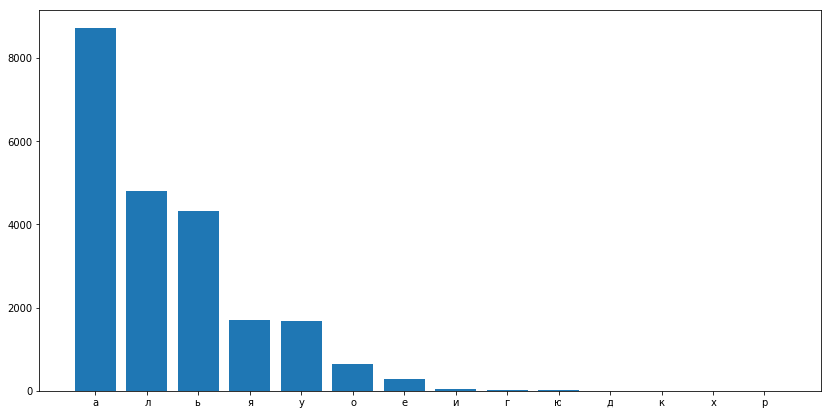

In [78]:
diag('лары')

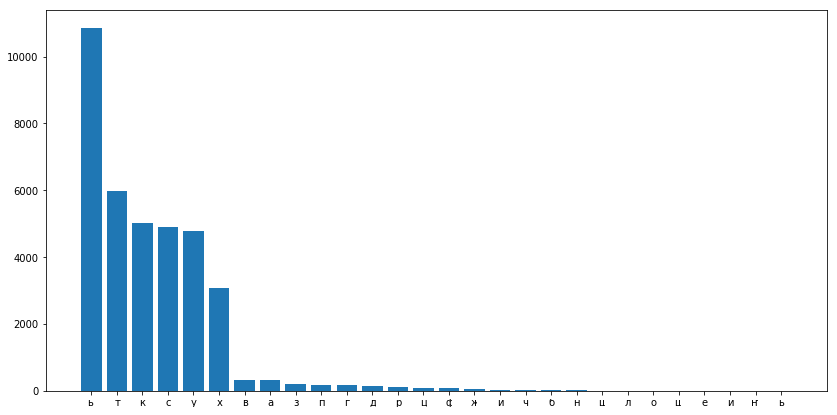

In [79]:
diag('тары')

In [10]:
print(n2('ан'))
print((155812+226046)/(105460+78300))

[('н', 226046), ('т', 155812), ('а', 105460), ('р', 78300), ('л', 63944), ('х', 40317), ('й', 29959), ('һ', 24992), ('ь', 15640), ('с', 14718), ('ы', 9975), ('ҕ', 9912), ('д', 8410), ('в', 4265), ('м', 3512), ('г', 1700), ('б', 1647), ('п', 1378), ('ҥ', 1091), ('и', 271), ('ж', 249), ('к', 232), ('з', 221), ('ч', 58), ('ф', 38), ('е', 28), ('ш', 23), ('у', 19), ('о', 9), ('ц', 8), ('ө', 2), ('ү', 1), ('я', 1), ('щ', 1)]
2.07802568567697


In [11]:
3703/776

4.771907216494846

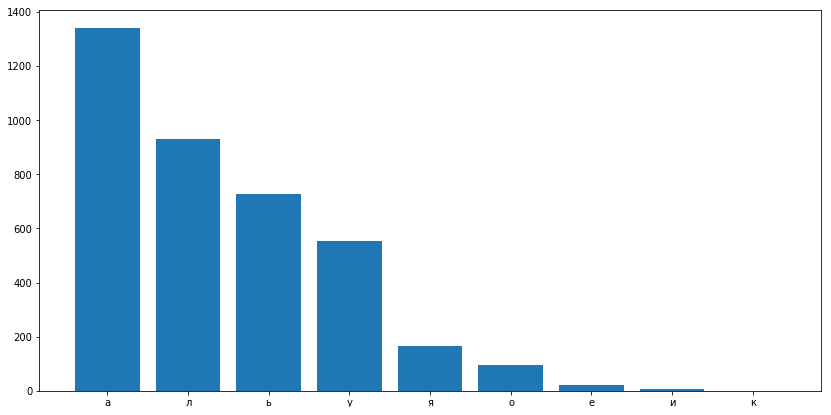

In [12]:
diag('лартан')

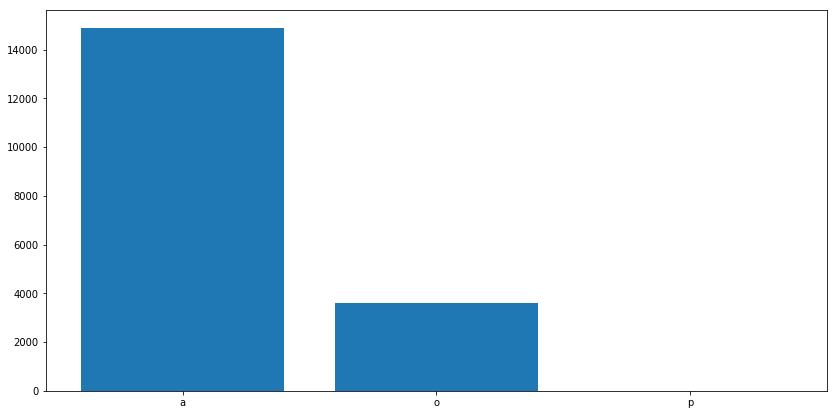

In [13]:
diag('хтара')

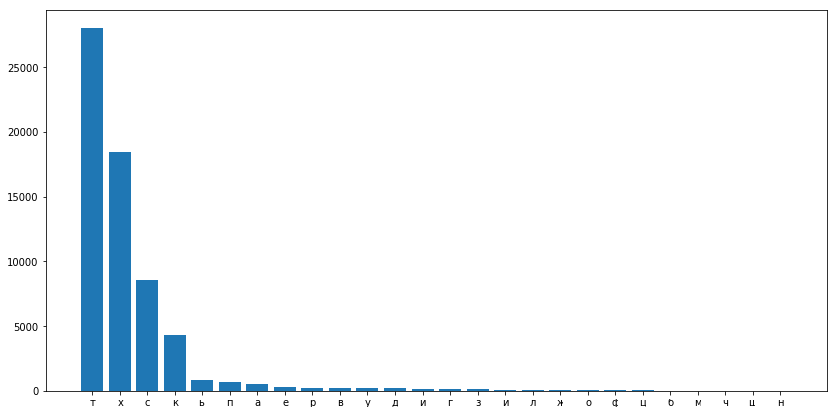

In [14]:
diag('тара')

### при информанте "н" начнем расширять аффикс

In [15]:
print(n2('н'))

[('а', 798469), ('э', 500106), ('ы', 462367), ('и', 376365), ('о', 192704), ('у', 127619), ('ү', 92134), ('ө', 42450), ('е', 5962), ('я', 925), ('й', 386), ('н', 121), ('р', 117), ('л', 109), ('ю', 40), ('т', 40), ('ё', 38), ('ш', 25), ('м', 22), ('ь', 17), ('б', 13), ('г', 6), ('к', 4), ('ц', 3), ('х', 3), ('п', 2), ('с', 2), ('в', 2), ('ж', 1), ('ҥ', 1), ('ҕ', 1), ('д', 1), ('һ', 1)]


In [16]:
798469/500106 #(>1.5)

1.5965995209015689

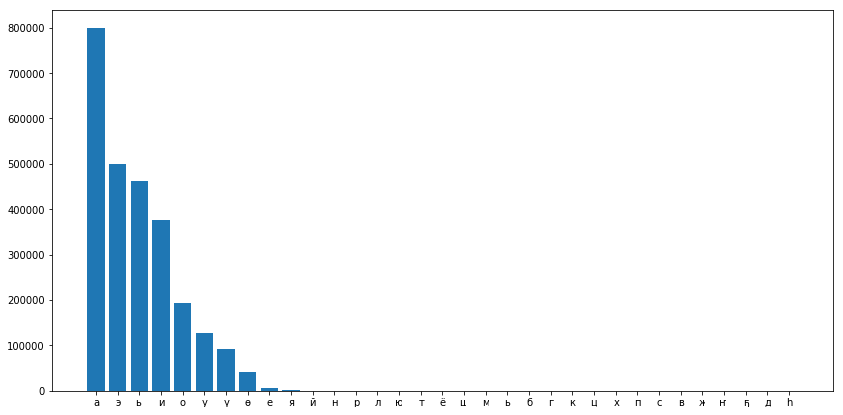

In [65]:
diag('н')

In [19]:
print(n2('ан'))#также есть суффикс -ан

[('н', 226046), ('т', 155812), ('а', 105460), ('р', 78300), ('л', 63944), ('х', 40317), ('й', 29959), ('һ', 24992), ('ь', 15640), ('с', 14718), ('ы', 9975), ('ҕ', 9912), ('д', 8410), ('в', 4265), ('м', 3512), ('г', 1700), ('б', 1647), ('п', 1378), ('ҥ', 1091), ('и', 271), ('ж', 249), ('к', 232), ('з', 221), ('ч', 58), ('ф', 38), ('е', 28), ('ш', 23), ('у', 19), ('о', 9), ('ц', 8), ('ө', 2), ('ү', 1), ('я', 1), ('щ', 1)]


In [20]:
226046/155812

1.450761173722178

In [21]:
(226046+155812)/(105460+78300)#>2

2.07802568567697

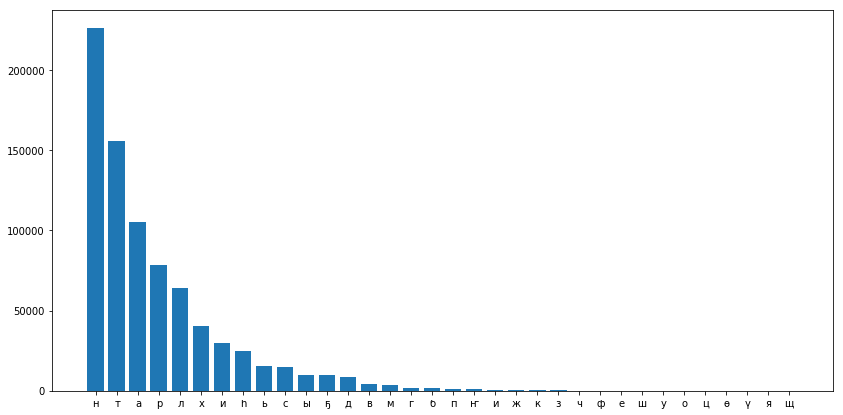

In [66]:
diag('ан')

In [22]:
print(n2('нан')) #-нан - аффикс орудного падежа

[('ы', 128013), ('у', 63359), ('а', 30825), ('я', 1482), ('м', 853), ('о', 841), ('ҥ', 254), ('е', 238), ('и', 114), ('н', 54), ('ю', 4), ('э', 4), ('ү', 1), ('р', 1)]


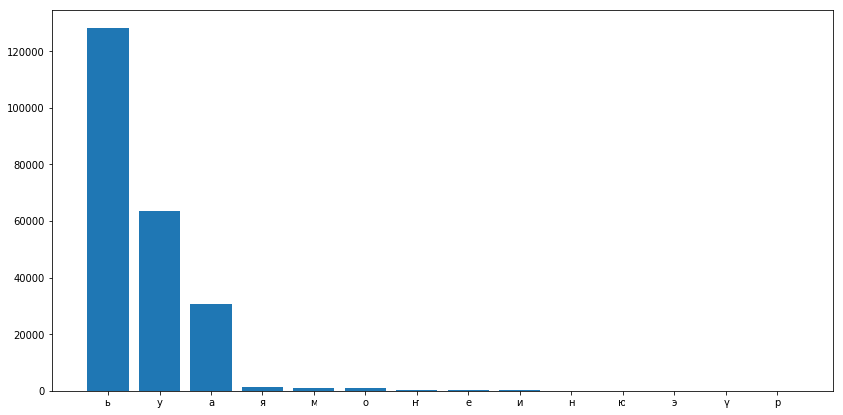

In [67]:
diag('нан')

In [28]:
print(n2('ынан')) #аффикс орудного падежа притяжат склонение

[('т', 37319), ('р', 25048), ('һ', 15515), ('г', 13760), ('л', 9141), ('ҕ', 6722), ('н', 5322), ('й', 4933), ('ы', 2237), ('к', 2026), ('ч', 1964), ('б', 1214), ('м', 761), ('д', 675), ('п', 601), ('ь', 223), ('ҥ', 194), ('в', 117), ('с', 103), ('х', 98), ('ш', 3), ('ө', 2), ('я', 1)]


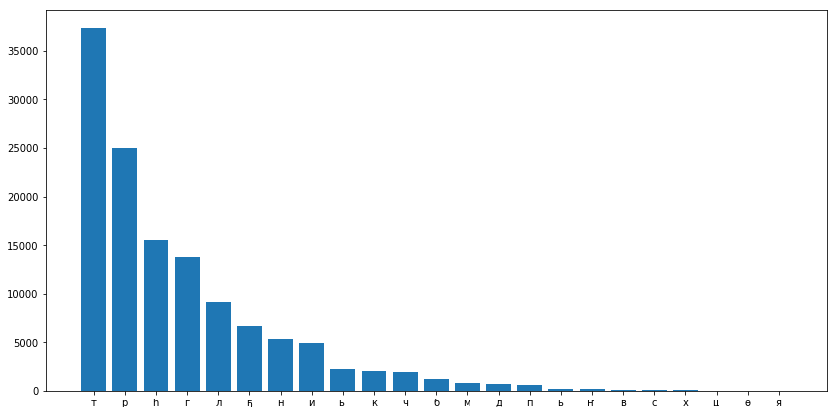

In [68]:
diag('ынан')

In [24]:
(37319+25048)/(15515+13760)

2.130384286934244

In [25]:
print(n2('тынан'))#аффикса -тынан нет

[('ы', 23981), ('а', 12000), ('с', 370), ('я', 309), ('т', 173), ('е', 161), ('о', 106), ('к', 58), ('и', 56), ('р', 46), ('п', 21), ('э', 19), ('н', 9), ('й', 7), ('ь', 2), ('л', 1)]


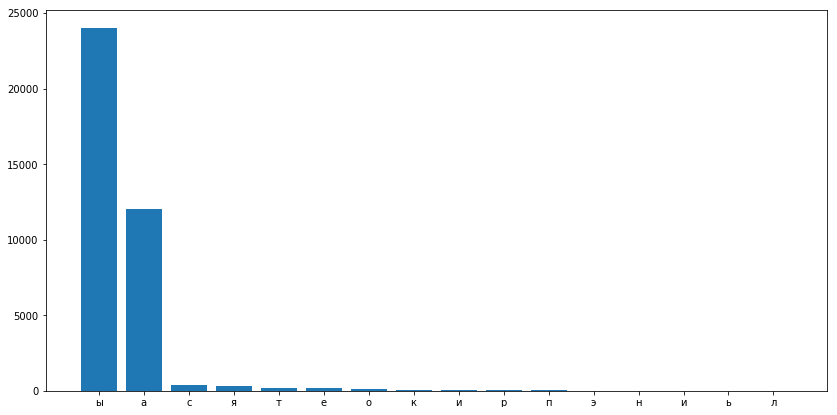

In [69]:
diag('тынан')

In [26]:
23981/12000

1.9984166666666667

In [63]:
n('ынан')/n('тынан')

3.430236608697982

In [64]:
n('нан')/n('ынан')

1.7658050354260895

In [29]:
print(n2('ытынан'))

[('ы', 17491), ('б', 2501), ('п', 960), ('ч', 787), ('к', 504), ('м', 398), ('с', 292), ('г', 231), ('ь', 207), ('т', 182), ('һ', 117), ('р', 117), ('л', 44), ('ҕ', 37), ('х', 22), ('ҥ', 15), ('й', 9)]


In [32]:
print(n('ытынан'))

23981


In [38]:
print(n('ыытынан'))

17491


In [39]:
print(n2('ыытынан'))

[('һ', 15345), ('р', 805), ('й', 636), ('т', 205), ('м', 135), ('н', 90), ('д', 79), ('л', 57), ('ҕ', 47), ('с', 30), ('ь', 25), ('б', 15), ('г', 11), ('ы', 1), ('ҥ', 1)]


In [40]:
print(n('һыытынан'))

15345


In [41]:
print(n2('һыытынан'))

[('ы', 15310), ('а', 35)]


In [42]:
print(n('ыһыытынан'))

15310


In [43]:
print(n2('ыһыытынан'))

[('б', 15251), ('д', 34), ('с', 4), ('т', 3), ('н', 2)]


In [44]:
print(n2('быһыытынан'))

[('а', 1), ('ы', 1), ('б', 1)]


In [33]:
print(n('бытынан'))

2501


In [34]:
print(n2('бытынан'))

[('а', 790), ('р', 630), ('ы', 540), ('л', 316), ('й', 210), ('я', 8), ('о', 3), ('е', 2), ('ь', 1), ('и', 1)]


In [36]:
(790+630)/(540+316)

1.658878504672897

In [37]:
540/316

1.7088607594936709

In [45]:
print(n2('р'))

[('а', 784102), ('э', 489099), ('и', 111886), ('о', 87158), ('ы', 40056), ('ө', 36238), ('у', 29417), ('ү', 17432), ('е', 7434), ('т', 6426), ('д', 6354), ('с', 762), ('р', 365), ('ё', 183), ('я', 155), ('г', 148), ('п', 62), ('в', 62), ('н', 59), ('ю', 26), ('к', 21), ('б', 12), ('ф', 12), ('х', 7), ('й', 6), ('м', 4), ('л', 3), ('ҕ', 2)]


In [46]:
print(n2('ар'))

[('г', 205162), ('л', 186545), ('т', 138686), ('р', 56553), ('а', 42586), ('н', 40307), ('й', 22014), ('ь', 19403), ('ҕ', 15533), ('д', 15375), ('б', 11988), ('һ', 10283), ('с', 9489), ('п', 4398), ('ы', 2760), ('м', 814), ('ҥ', 711), ('к', 530), ('х', 512), ('в', 166), ('у', 77), ('з', 62), ('и', 55), ('ш', 29), ('ч', 15), ('ф', 15), ('ө', 5), ('е', 2), ('ю', 2), ('ц', 1), ('ж', 1)]


In [50]:
(205162+186545)/(138686+56553)

2.0062948488775296

In [48]:
186545/138686

1.3450889058737003

In [52]:
print(n('гар'))

205162


In [53]:
print(n2('гар'))#дательный падеж притяжат склонения

[('ы', 149987), ('у', 52493), ('а', 1049), ('о', 647), ('р', 579), ('и', 139), ('л', 110), ('е', 102), ('й', 16), ('н', 16), ('д', 11), ('ю', 5), ('я', 3), ('т', 2), ('г', 1), ('к', 1)]


In [54]:
149987/52493

2.857276208256339

In [55]:
print(n('ыгар'))

149987


In [56]:
print(n2('ыгар'))

[('т', 60289), ('р', 50637), ('һ', 11643), ('л', 8064), ('н', 6970), ('й', 3851), ('д', 3720), ('м', 1956), ('б', 1600), ('ь', 308), ('с', 281), ('п', 187), ('в', 149), ('ж', 99), ('ч', 57), ('ы', 46), ('ҕ', 40), ('ҥ', 19), ('г', 9), ('ш', 4), ('а', 1), ('к', 1)]


In [57]:
print(n('ыгар'))

149987


In [59]:
print(n2('тыгар'))

[('а', 29433), ('ы', 22570), ('я', 3080), ('е', 1763), ('т', 1695), ('о', 1089), ('й', 243), ('р', 228), ('л', 34), ('и', 30), ('с', 30), ('э', 6), ('ю', 3), ('н', 2), ('к', 2), ('ж', 1), ('ө', 1)]


In [80]:
print(n('т'))

666056


In [87]:
print(n2('т'))

[('ы', 182423), ('и', 165006), ('у', 86326), ('а', 71661), ('ү', 45370), ('э', 37005), ('р', 22656), ('о', 22396), ('е', 8470), ('н', 7559), ('ө', 6322), ('с', 5011), ('к', 2461), ('л', 1284), ('в', 455), ('ь', 402), ('й', 299), ('я', 228), ('ю', 226), ('ф', 150), ('т', 140), ('п', 75), ('д', 43), ('х', 29), ('ё', 22), ('ш', 17), ('м', 12), ('б', 6), ('г', 1), ('ч', 1)]


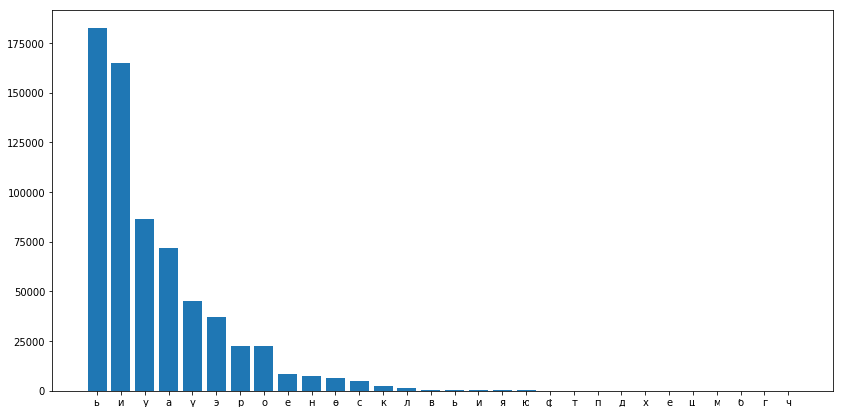

In [82]:
diag('т')

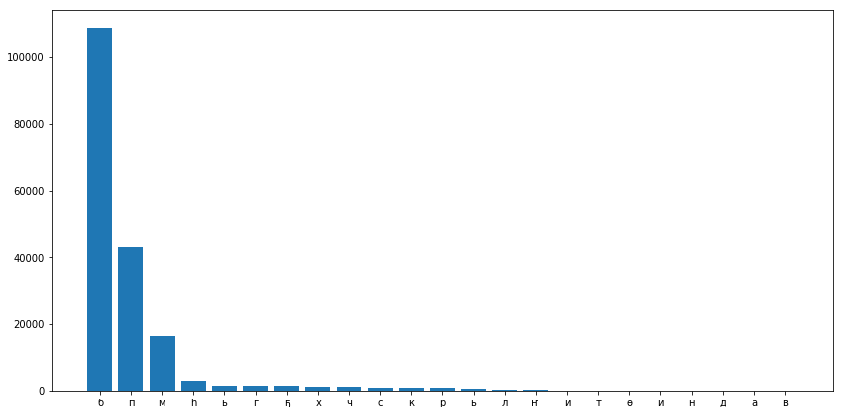

In [83]:
diag('ыт')

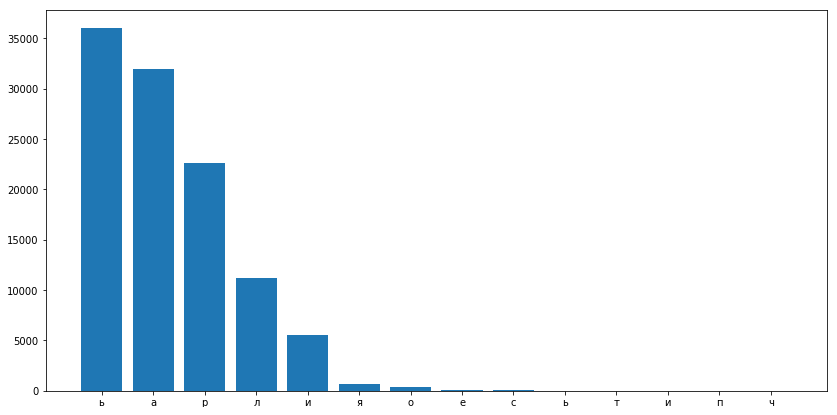

In [84]:
diag('быт')

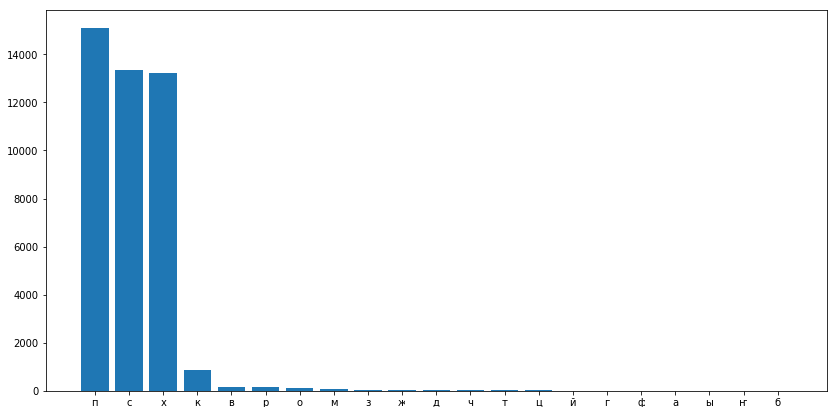

In [85]:
diag('пыт')

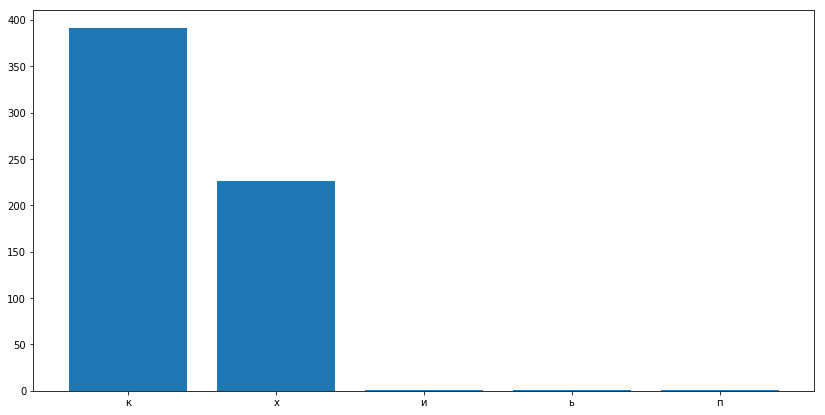

In [88]:
diag('сыт')

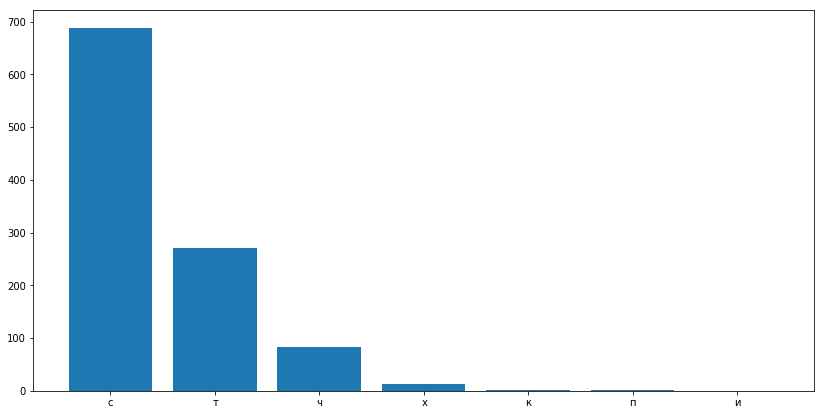

In [89]:
diag('чыт')

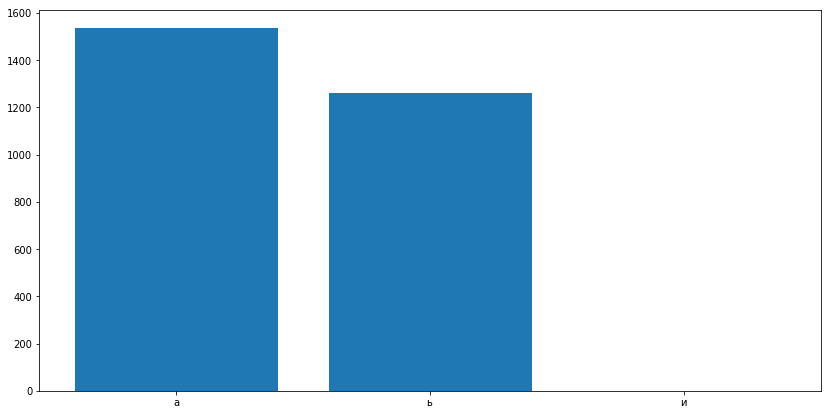

In [90]:
diag('һыт')

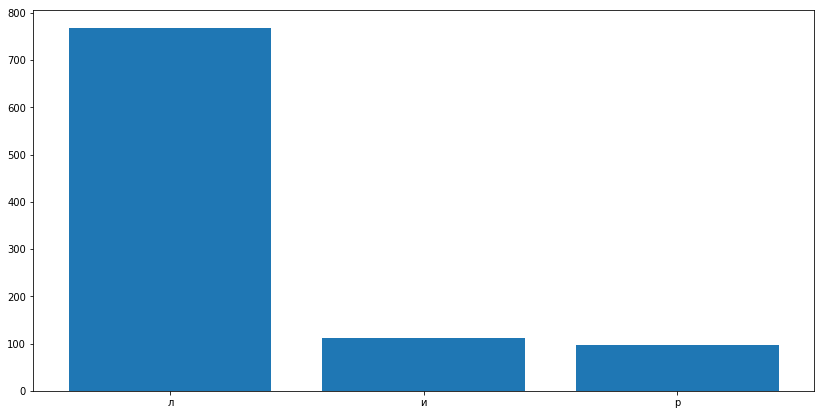

In [92]:
diag('дьыт')

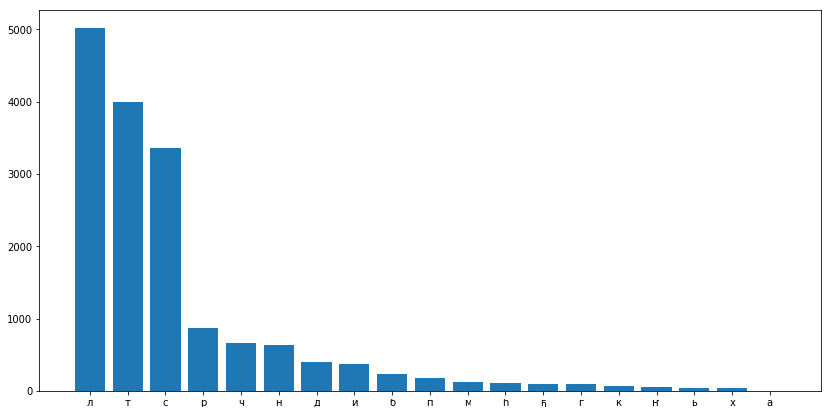

In [93]:
diag('ааһын')

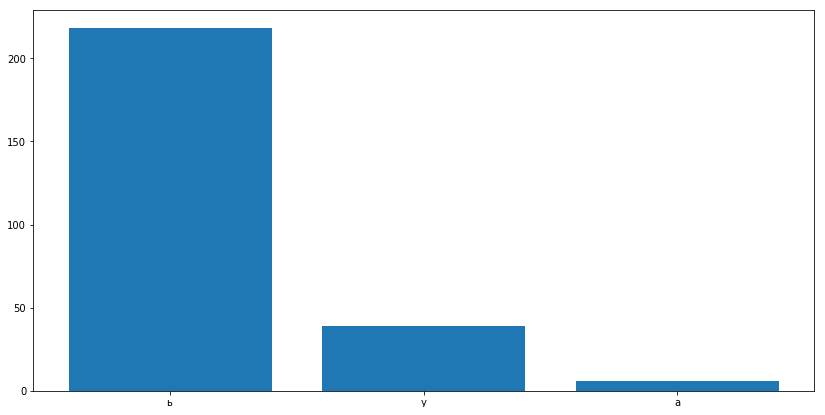

In [94]:
diag('мсах')

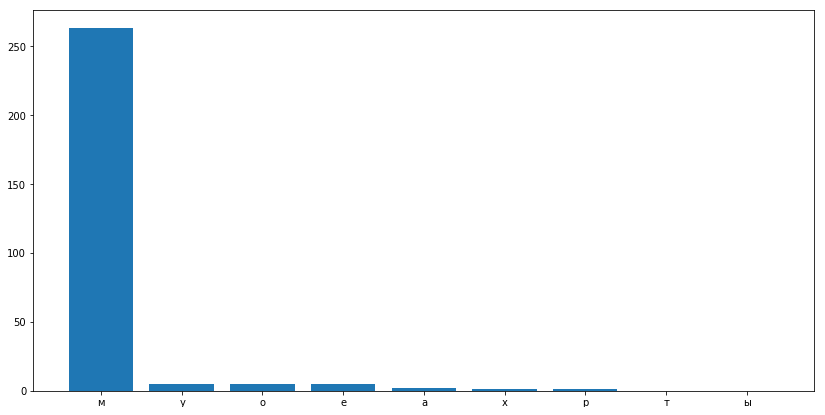

In [95]:
diag('сах')

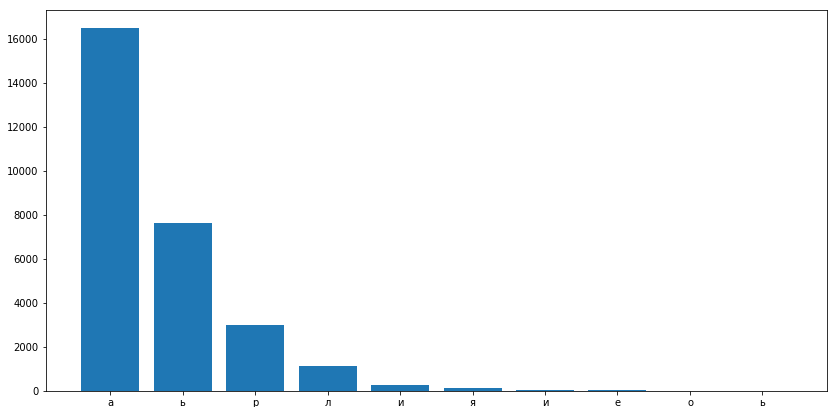

In [96]:
diag('бын')

In [40]:
diag('абын')

NameError: name 'diag' is not defined

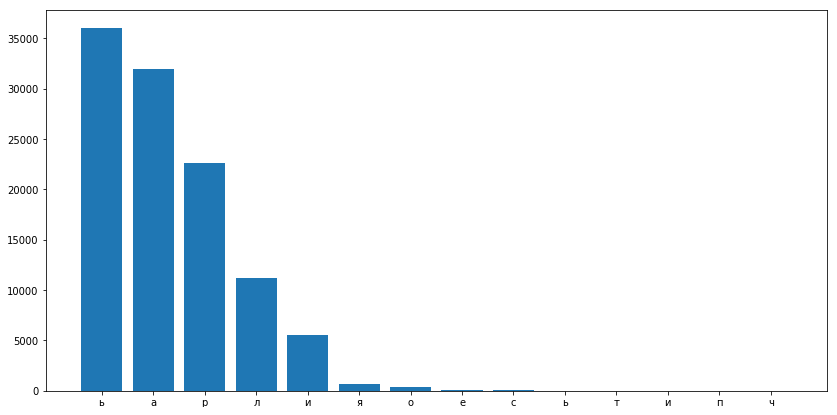

In [98]:
diag('быт')

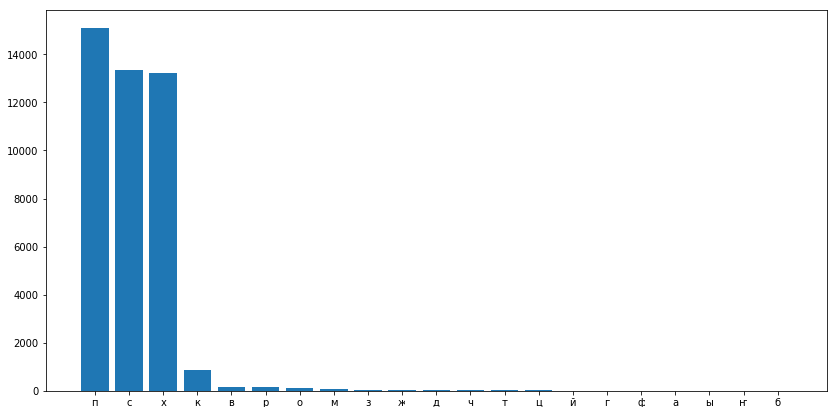

In [99]:
diag('пыт')

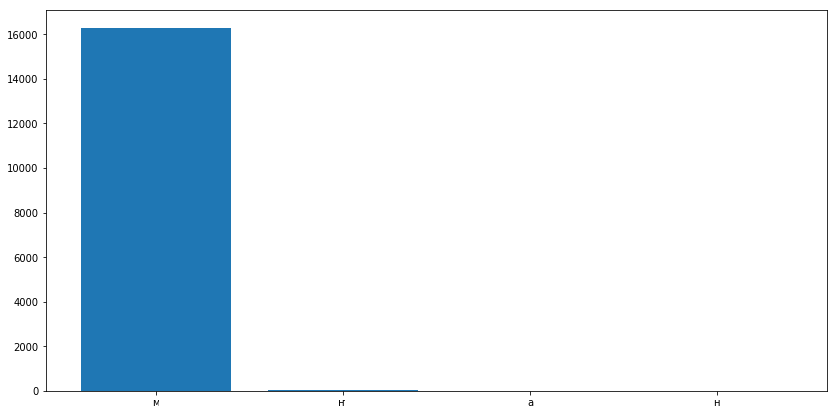

In [105]:
diag('мыт')

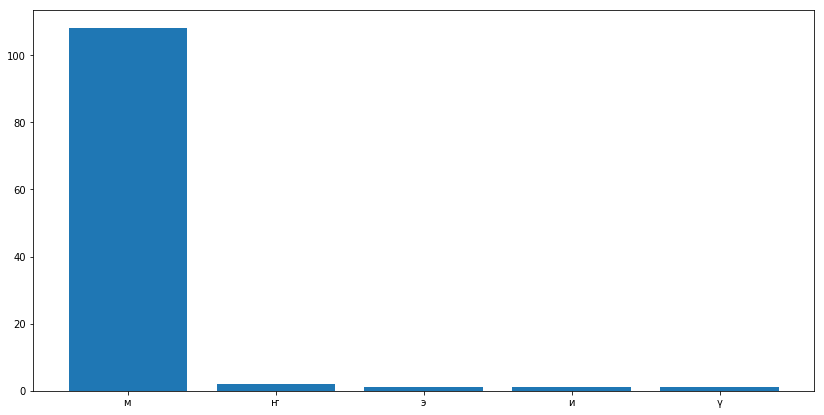

In [34]:
diag('мэт')

In [32]:
sorted([w for w in words if w[-4:]=='сбат'])

['дисбат']

In [39]:
len(sorted([w for w in words if w[-5:]=='ботох']))

31

In [22]:
def stem(affix):
    return(sorted([w for w in words if w[-len(affix):]==affix]))
    

In [38]:
7

7

за основы принимаем элементы stem-affix(отрезать аффикс). До агглютинативной 